# Import Libraries

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.similarities import pearson
from surprise import Dataset, Reader
from surprise import accuracy
from sklearn.metrics import mean_squared_error

# Obtain Data

In [2]:
df = pd.read_csv('beer_reviews.csv')
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [4]:
df = df[['review_profilename','beer_beerid','review_time','review_overall']]
df.head()

,review_profilename,beer_beerid,review_time,review_overall
0,stcules,47986,1234817823,1.5
1,stcules,48213,1235915097,3.0
2,stcules,48215,1235916604,3.0
3,stcules,47969,1234725145,3.0
4,johnmichaelsen,64883,1293735206,4.0


# Scrub Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 4 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   review_profilename  1586266 non-null  object 
 1   beer_beerid         1586614 non-null  int64  
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 48.4+ MB


In [6]:
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586266 entries, 0 to 1586613
Data columns (total 4 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   review_profilename  1586266 non-null  object 
 1   beer_beerid         1586266 non-null  int64  
 2   review_time         1586266 non-null  int64  
 3   review_overall      1586266 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 60.5+ MB


In [7]:
df['review_overall'] = df['review_overall']*2
df['review_overall'] = df['review_overall'].astype(int)
df.head()

,review_profilename,beer_beerid,review_time,review_overall
0,stcules,47986,1234817823,3
1,stcules,48213,1235915097,6
2,stcules,48215,1235916604,6
3,stcules,47969,1234725145,6
4,johnmichaelsen,64883,1293735206,8


In [8]:
df.to_csv('formatted_beer_reviews.csv', index=False)

# Explore Data

In [9]:
df['review_overall'].mean()

7.631256044068271

In [10]:
df['review_overall'].std()

1.4411896227439236

In [11]:
df['review_overall'].mode()

0    8
dtype: int64

Text(0.5, 1.0, 'Frequency Count by Review Score')

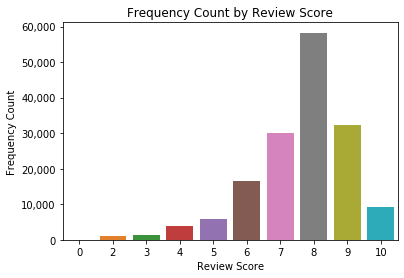

In [31]:
countplot = sns.countplot(x='review_overall',data=df)
countplot.set_yticklabels(['0','10,000','20,000','30,000','40,000','50,000','60,000'])
countplot.set_xlabel('Review Score')
countplot.set_ylabel('Frequency Count')
countplot.set_title('Frequency Count by Review Score')

In [14]:
df.groupby('review_overall').count().iloc[:,0]

review_overall
0          7
2      10954
3      12973
4      38207
5      58486
6     165583
7     301750
8     582684
9     324323
10     91299
Name: review_profilename, dtype: int64

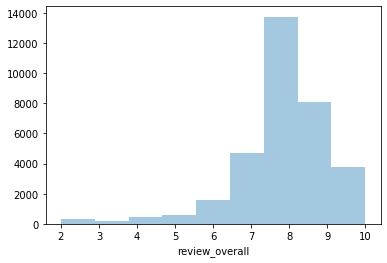

In [16]:
user_mean = df.groupby('review_profilename').mean()['review_overall']
sns.distplot(user_mean, kde=False, bins=9)

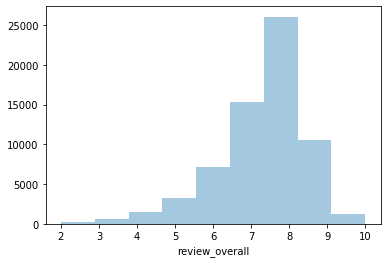

In [17]:
bear_mean = df.groupby('beer_beerid').mean()['review_overall']
sns.distplot(bear_mean, kde=False, bins=9)

In [27]:
user_review_count = df.groupby('review_profilename').count().iloc[:,0]
user_review_count.describe()

count    33387.000000
mean        47.511487
std        182.599759
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max       5817.000000
Name: beer_beerid, dtype: float64

In [22]:
beer_review_count = df.groupby('beer_beerid').count().iloc[:,0]
beer_review_count.describe()

count    66051.000000
mean        24.015776
std        110.838706
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       3289.000000
Name: review_profilename, dtype: float64

In [70]:
print(beer_review_count['review_profilename'].mean())
print(beer_review_count['review_profilename'].std())

24.015775688483142
110.8387060869541


In [65]:
beer_review_count

,review_profilename,review_time,review_overall
beer_beerid,,,
3,3,3,3
4,10,10,10
5,424,424,424
6,877,877,877
7,659,659,659
...,...,...,...
77313,1,1,1
77314,1,1,1
77315,1,1,1


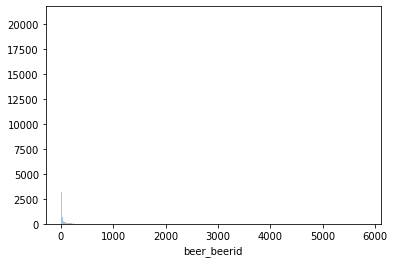

In [58]:
user_review_count = df.groupby('review_profilename').count().iloc[:,0]
sns.distplot(user_review_count, kde=False, bins=1000)

In [11]:
df.columns

Index(['review_profilename', 'beer_beerid', 'review_time', 'review_overall'], dtype='object')

# Model Data

In [62]:
reader = Reader(rating_scale=(0,10), line_format='user item timestamp rating', 
                sep = ',',skip_lines=1)
dataset = Dataset.load_from_file('formatted_beer_reviews.csv', reader)
trainset, testset = train_test_split(dataset, test_size=0.2, random_state = 71)

baseline model

In [57]:
baseline_pred = np.array([df['review_overall'].mean()]*len(df['review_overall']))
actuals = np.array(df['review_overall'])
baseline_rmse = sum(np.square((baseline_pred-actuals)))/len(df['review_overall'])
baseline_mae = sum(np.abs((baseline_pred-actuals)))/len(df['review_overall'])
print('MAE: ', baseline_mae)
print('RMSE: ', baseline_rmse)

MAE:  1.103270578412246
RMSE:  2.0770262193231632


In [15]:
knn = KNNBasic(k=1, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  1.2679
RMSE: 1.7401


1.7401124714867655

In [16]:
knn = KNNBasic(k=10, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9699
RMSE: 1.2989


1.298942909831698

In [17]:
knn = KNNBasic(k=20, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9461
RMSE: 1.2712


1.2712010880925555

In [81]:
knn = KNNBasic(k=30, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9387
RMSE: 1.2626


1.2625541391381911

In [82]:
knn = KNNBasic(k=40, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9352
RMSE: 1.2585


1.2584695805088943

In [29]:
svd = SVD(n_factors=10, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MAE:  0.9070
RMSE: 1.2127


1.2126710248453587

In [85]:
svd = SVD(n_factors=20, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MAE:  0.9067
RMSE: 1.2122


1.2121917187118258

In [86]:
svd = SVD(n_factors=15, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MAE:  0.9073
RMSE: 1.2130


1.2130049606536653

In [87]:
svd = SVD(n_factors=25, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MAE:  0.9062
RMSE: 1.2117


1.211691768656642